In [29]:
#MSE vs サーチケース
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error, roc_auc_score, r2_score

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.neural_network import MLPRegressor
import itertools
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D

#reaction length
df = pd.read_excel('/mnt/c/CEA/all_mixtureexp16.xlsx')

output = 'Tcj[K]'

l1=['Fuel','Diluent','Equivalentratio','CoefficientDiluent','Oxidizer','diluentratio','P0', 'H0[KJ/kg]', 'M0[kg/kmol]', 'γ0[-]','Lc', output]

#'Ea[KJ/kg]', 'theta' , 'inductionlength'

XpcaFLRDED = pd.DataFrame({'P0':df['P0']})

for i in range(len(l1)):
    XpcaFLRDED[l1[i]]=df[l1[i]]

def calc_double(n):
    return n/100

XpcaFLRDED['Tcj[K]'] = list(map(calc_double,XpcaFLRDED['Tcj[K]']))

print(XpcaFLRDED['Tcj[K]'])

XpcaFLRDED =  XpcaFLRDED[~( XpcaFLRDED['Fuel'] == 'C2H2') | ~( XpcaFLRDED['Diluent'] == 'Ar') | ~( XpcaFLRDED['Lc'] ==  5)]
XpcaFLRDED =  XpcaFLRDED[~( XpcaFLRDED['Fuel'] == 'C2H2') | ~( XpcaFLRDED['Diluent'] == 'Ar') | ~( XpcaFLRDED['Lc'] ==  10)]
XpcaFLRDED =  XpcaFLRDED[~( XpcaFLRDED['Diluent'] == 'Kr')]

dfC2H2N2train = XpcaFLRDED[~( XpcaFLRDED['Fuel'] == 'C2H2') | ~( XpcaFLRDED['Diluent'] == 'N2')]
dfC2H2N2test = XpcaFLRDED[( XpcaFLRDED['Fuel'] == 'C2H2') & ( XpcaFLRDED['Diluent'] == 'N2')]

dfC2H2Hetrain = dfC2H2N2train[~( dfC2H2N2train['Fuel'] == 'C2H2') | ~( dfC2H2N2train['Diluent'] == 'He')]
dfC2H2Hetest = dfC2H2N2train[( dfC2H2N2train['Fuel'] == 'C2H2') & ( dfC2H2N2train['Diluent'] == 'He')]

dfC2H6N2Otrain =  dfC2H2Hetrain[~( dfC2H2Hetrain['Fuel'] == 'C2H6') | ~( dfC2H2Hetrain['Oxidizer'] == 'N2O')]
dfC2H6N2Otest = dfC2H2Hetrain[( dfC2H2Hetrain['Fuel'] == 'C2H6') & ( dfC2H2Hetrain['Oxidizer'] == 'N2O')]

dfC3H6O2train =  dfC2H6N2Otrain[~( dfC2H6N2Otrain['Fuel'] == 'C3H6') | ~( dfC2H6N2Otrain['Oxidizer'] == 'O2')]
dfC3H6O2test = dfC2H6N2Otrain[( dfC2H6N2Otrain['Fuel'] == 'C3H6') & ( dfC2H6N2Otrain['Oxidizer'] == 'O2')]

dfC3H6N2Otrain =  dfC3H6O2train[~( dfC3H6O2train['Fuel'] == 'C3H6') | ~( dfC3H6O2train['Oxidizer'] == 'N2O')]
dfC3H6N2Otest = dfC3H6O2train[( dfC3H6O2train['Fuel'] == 'C3H6') & ( dfC3H6O2train['Oxidizer'] == 'N2O')]

dftrainval = dfC3H6N2Otrain.sample(frac=1)

X_train = dftrainval.drop(columns=['Diluent','Fuel','Equivalentratio','CoefficientDiluent','Oxidizer',output,'Lc','diluentratio'])

y_train = dftrainval[output]

ss = StandardScaler()
sX_train = ss.fit_transform(X_train)
sX_train = pd.DataFrame(sX_train,columns=X_train.columns)

0      34.9523
1      35.0216
2      35.0624
3      35.3270
4      35.4202
        ...   
822    37.5946
823    37.9516
824    37.1582
825    36.6498
826    35.8668
Name: Tcj[K], Length: 827, dtype: float64


In [30]:
sol = ['adam']
act = ['relu']
hidd = []

for i in [4]:
    for j in [200]:
        b=[j]*i
        b=tuple(b)
        hidd.append(b)

alp=[1e-4]
param_grid = {'solver':sol,'activation':act,'hidden_layer_sizes':hidd,'alpha':alp}
grid1=GridSearchCV(MLPRegressor(), param_grid ,cv=2, n_jobs=4)
grid1.fit(sX_train,y_train)

print('Best parameters: {}'.format(grid1.best_params_))
print('Best cross-validation: {}'.format(grid1.best_score_))

/home/hiroki/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hiroki/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (200, 200, 200, 200), 'solver': 'adam'}
Best cross-validation: 0.936832058921607


/home/hiroki/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


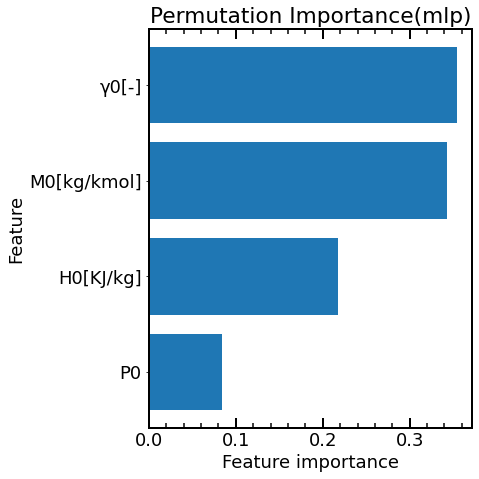

In [31]:
def plot_feature_importance(df):
    n_features = len(df)
    df_plot = df.sort_values('importance')
    f_importance_plot = df_plot['importance'].values
    plt.barh(range(n_features), f_importance_plot, align='center')
    cols_plot = df_plot['feature'].values
    plt.yticks(np.arange(n_features), cols_plot)
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

result = permutation_importance(grid1,sX_train,y_train, n_repeats=5, random_state=42)

cols = list(sX_train.columns)         # 特徴量名のリスト(目的変数CRIM以外)
f_importance = np.array(result["importances"].mean(axis=1)) # 特徴量重要度の算出
f_importance = f_importance / np.sum(f_importance)  # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df1=df_importance
df_importance = df_importance.sort_values("importance",ascending=False)

plt.figure(figsize=(7,7))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

# Tick Setting
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
#sns.barplot(x="Importance", y="Features",data=df_importance,ci=None)
plot_feature_importance(df_importance)
plt.title("Permutation Importance(mlp)")
plt.tight_layout()